#### Q) It seems that the model is missing the California Under Current (CUC).  Is it absent or just shifted offshore a bit? 

#### Q) How does this influence our ideas about upwelling ?

In [14]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
def find_principal_axis_of_dataset_in_degrees(u_data,v_data):
    
    u_perturb = u_data - np.mean(u_data)
    v_perturb = v_data - np.mean(v_data)
    
    coords = np.vstack([u_perturb, v_perturb])

    cov = np.cov(coords)
    
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    
    theta = np.tanh((x_v1)/(y_v1))  
#     rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
#                       [np.sin(theta), np.cos(theta)]])
#     transformed_mat = rotation_mat * coords
#     # plot the transformed blob
#     x_transformed, y_transformed = transformed_mat.A

    return np.rad2deg(theta)

def find_major_eigenvectors(u_data,v_data):
    
    u_data = u_data[~np.isnan(u_data)]
    v_data = v_data[~np.isnan(v_data)]
    
    u_perturb = u_data - np.mean(u_data)
    v_perturb = v_data - np.mean(v_data)
    
    coords = np.vstack([u_perturb, v_perturb])

    cov = np.cov(coords)
    
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    
    return x_v1, y_v1, x_v2, y_v2


    
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)




def uv_wind_timeseries_at_point(grid_weather, j, i, datetimes=False):
    """Return the u and v wind components and time counter values
    at a single grid point from a weather forcing dataset.

    :arg grid_weather: Weather forcing dataset, typically from an
                       :file:`ops_yYYYYmMMdDD.nc` file produced by the
                       :py:mod:`nowcast.workers.grid_to_netcdf` worker.
    :type grid_weather: :py:class:`netCDF4.Dataset`

    :arg int j: j-direction (longitude) index of grid point to get wind
                components at.

    :arg int i: i-direction (latitude) index of grid point to get wind
                components at.

    :arg boolean datetimes: Return time counter values as
                            :py:class:`datetime.datetime` objects if
                            :py:obj:`True`, otherwise return them as
                            :py:class:`arrow.Arrow` objects (the default).

    :returns: 2-tuple of 1-dimensional :py:class:`numpy.ndarray` objects,
              The :py:attr:`u` attribute holds the u-direction wind
              component,
              The :py:attr:`v` attribute holds the v-direction wind
              component,
              and the :py:attr:`time` attribute holds the time counter
              values.
    :rtype: :py:class:`collections.namedtuple`
    """
    u_wind = grid_weather.variables['u_wind'][:, j, i]
    v_wind = grid_weather.variables['v_wind'][:, j, i]
    time = timestamp(grid_weather, range(len(u_wind)))
    if datetimes:
        time = np.array([a.datetime for a in time])
    wind_ts = namedtuple('wind_ts', 'u, v, time')

    return wind_ts(u_wind, v_wind, np.array(time))

def timestamp(dataset, tindex, time_var='time_counter'):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or iterable

    :arg time_var: name of the time variable
    :type time_var: str

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset, time_var=time_var)
    time_counter = dataset.variables[time_var]
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:

        return results[0]

def time_origin(dataset, time_var='time_counter'):
    """Return the time_var.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset` or :py:class:`xarray.Dataset`

    :arg time_var: name of time variable
    :type time_var: str

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables[time_var]
    except KeyError:
        raise KeyError(
            'dataset does not have {time_var} variable'.format(
                time_var=time_var))
    try:
        # netCDF4 dataset
        time_orig = time_counter.time_origin.title()
    except AttributeError:
        try:
            # xarray dataset
            time_orig = time_counter.attrs['time_origin'].title()
        except KeyError:
            raise AttributeError(
                'NetCDF: '
                '{time_var} variable does not have '
                'time_origin attribute'.format(time_var=time_var))
    value = arrow.get(
        time_orig,
        ['YYYY-MMM-DD HH:mm:ss',
         'DD-MMM-YYYY HH:mm:ss',
         'YYYY-MM-DD HH:mm:ss'])

    return value

import numpy

def smooth(x,window_len=24,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s, mode='same')
    
    return y[window_len - 1:-window_len + 1]

    
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in np.arange(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df









"""
Constants
=========
"""

# ---- physical constants
g = 9.8  # 9.7803 in COARE FIXME: change to sw.grav
""" acceleration due to gravity [m s :sup:`-2`] """

sigmaSB = 5.6697e-8
""" Stefan-Boltzmann constant [W m :sup:`-2` K :sup:`-4`] """

eps_air = 0.62197
""" Molecular weight ratio [water air :sup:`-1`] """

CtoK = 273.15  # 273.16
""" Conversion factor for [:math:`^\\circ` C] to [:math:`^\\circ` K] """

gas_const_R = 287.04  # NOTE: 287.1 in COARE
""" Gas constant for dry air [J kg :sup:`-1` K :sup:`-1`] """


# ---- meteorological constants
kappa = 0.4  # NOTE: 0.41
""" von Karman's constant """

charn = Charnock_alpha = 0.011  # NOTE: 0.018
""" Charnock constant. For determining roughness length at sea given friction
velocity, used in Smith formulas for drag coefficient and also in Fairall and
Edson. Ese alpha = 0.011 for open-ocean and alpha = 0.018 for fetch-limited
(coastal) regions."""

R_roughness = 0.11
""" limiting roughness Reynolds for aerodynamically smooth flow """


# ---- defaults suitable for boundary-layer studies
cp = 1004.7
""" heat capacity of air [J kg :sup:`-1` K :sup:`-1`] """

Qsat_coeff = 0.98
""" saturation specific humidity coefficient reduced by 2% over salt water """


# ------ short-wave flux calculations
Solar_const = 1368.0
""" The solar constant [W/m^2] represents a mean of satellite measurements
made over the last sunspot cycle (1979-1995) taken from Coffey et al (1995),
Earth System Monitor, 6, 6-10."""


# ---- long-wave flux calculations
emiss_lw = 0.985
""" long-wave emissivity of ocean from Dickey et al (1994), J. Atmos. Oceanic
Tech., 11, 1057-1076."""

# Default values
P_default = 1020.





def stress(sp, z=5., drag='largepond', rho_air=1.22, Ta=10.):
    """Computes the neutral wind stress.
    Parameters
    ----------
    sp : array_like
         wind speed [m s :sup:`-1`]
    z : float, array_like, optional
        measurement height [m]
    rho_air : array_like, optional
           air density [kg m :sup:`-3`]
    drag : str
           neutral drag by:
           'largepond' <-- default
           'smith'
           'vera'
    Ta : array_like, optional
         air temperature [:math:`^\\circ` C]
    Returns
    -------
    tau : array_like
          wind stress  [N m :sup:`-2`]
    See Also
    --------
    cdn
    Examples
    --------
    >>> from airsea import windstress as ws
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 10)
    array([  1.40300000e-01,   5.61200000e-05,   2.23113600e-01,
             8.73520000e-01,   2.67912000e+00,   1.14070000e+01])
    >>> kw = dict(rho_air=1.02, Ta=23.)
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 15, 'smith', **kw)
    array([  1.21440074e-01,   5.32531576e-05,   1.88322389e-01,
             6.62091968e-01,   1.85325310e+00,   7.15282267e+00])
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 8, 'vera')
    array([  1.50603698e-01,   7.16568379e-04,   2.37758830e-01,
             9.42518454e-01,   3.01119044e+00,   1.36422742e+01])
    References
    ----------
    .. [1] Large and Pond (1981), J. Phys. Oceanog., 11, 324-336.
    .. [2] Smith (1988), J. Geophys. Res., 93, 311-326.
    .. [3] E. Vera (1983) FIXME eqn. 8 in Large, Morzel, and Crawford (1995),
    J. Phys. Oceanog., 25, 2959-2971.
    Modifications: Original from AIR_SEA TOOLBOX, Version 2.0
    03-08-1997: version 1.0
    08-26-1998: version 1.1 (revised by RP)
    04-02-1999: versin 1.2 (air density option added by AA)
    08-05-1999: version 2.0
    11-26-2010: Filipe Fernandes, Python translation.
    """
    z, sp = np.asarray(z), np.asarray(sp)
    Ta, rho_air = np.asarray(Ta), np.asarray(rho_air)

    # Find cd and ustar.
    if drag == 'largepond':
        cd, sp = cdn(sp, z, 'largepond')
    elif drag == 'smith':
        cd, sp = cdn(sp, z, 'smith', Ta)
    elif drag == 'vera':
        cd, sp = cdn(sp, z, 'vera')
    else:
        print('Unknown method')  # FIXME: raise a proper python error

    tau = rho_air * (cd * sp ** 2)

    return tau


def cdn(sp, z, drag='largepond', Ta=10):
    """Computes neutral drag coefficient.
    Methods available are: Large & Pond (1981),  Vera (1983) or Smith (1988)
    Parameters
    ----------
    sp : array_like
         wind speed [m s :sup:`-1`]
    z : float, array_like
        measurement height [m]
    drag : str
           neutral drag by:
           'largepond' <-- default
           'smith'
           'vera'
    Ta : array_like, optional for drag='smith'
         air temperature [:math:`^\\circ` C]
    Returns
    -------
    cd : float, array_like
         neutral drag coefficient at 10 m
    u10 : array_like
          wind speed at 10 m [m s :sup:`-1`]
    See Also
    --------
    stress, spshft, visc_air
    Notes
    -----
    Vera (1983): range of fit to data is 1 to 25 [m s :sup:`-1`].
    Examples
    --------
    >>> from airsea import windstress as ws
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 10)
    (array([ 0.00115,  0.00115,  0.00127,  0.00179,  0.00244,  0.00374]),
     array([ 10. ,   0.2,  12. ,  20. ,  30. ,  50. ]))
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 15, 'vera')
    (array([ 0.00116157,  0.01545237,  0.00126151,  0.00174946,  0.00242021,
            0.00379521]),
     array([  9.66606155,   0.17761896,  11.58297824, 19.18652915,
            28.5750255 ,  47.06117334]))
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 20, 'smith', 20.)
    (array([ 0.00126578,  0.00140818,  0.00136533,  0.00173801,  0.00217435,
            0.00304636]),
     array([  9.41928554,   0.18778865,  11.27787697,  18.65250005,
            27.75712916,  45.6352786 ]))
    References
    ----------
    .. [1] Large and Pond (1981), J. Phys. Oceanog., 11, 324-336.
    .. [2] Smith (1988), J. Geophys. Res., 93, 311-326.
    .. [3] E. Vera (1983) FIXME eqn. 8 in Large, Morzel, and Crawford (1995),
    J. Phys. Oceanog., 25, 2959-2971.
    Modifications: Original from AIR_SEA TOOLBOX, Version 2.0
    03-08-1997: version 1.0
    08-26-1998: version 1.1 (vectorized by RP)
    08-05-1999: version 2.0
    11-26-2010: Filipe Fernandes, Python translation.
    """
    # convert input to numpy array
    sp, z, Ta = np.asarray(sp), np.asarray(z), np.asarray(Ta)

    tol = 0.00001  # Iteration end point.

    if drag == 'largepond':
        a = np.log(z / 10.) / kappa  # Log-layer correction factor.
        u10o = np.zeros(sp.shape)
        cd = 1.15e-3 * np.ones(sp.shape)
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol

        while np.any(ii):
            u10o = u10
            cd = (4.9e-4 + 6.5e-5 * u10o)  # Compute cd(u10).
            cd[u10o < 10.15385] = 1.15e-3
            u10 = sp / (1 + a * np.sqrt(cd))  # Next iteration.
            # Keep going until iteration converges.
            ii = np.abs(u10 - u10o) > tol

    elif drag == 'smith':
        visc = visc_air(Ta)

        # Remove any sp==0 to prevent division by zero
        # i = np.nonzero(sp == 0)
        # sp[i] = 0.1 * np.ones(len(i)) FIXME

        # initial guess
        ustaro = np.zeros(sp.shape)
        ustarn = 0.036 * sp

        # iterate to find z0 and ustar
        ii = np.abs(ustarn - ustaro) > tol
        while np.any(ii):
            ustaro = ustarn
            z0 = Charnock_alpha * ustaro ** 2 / g + R_roughness * visc / ustaro
            ustarn = sp * (kappa / np.log(z / z0))
            ii = np.abs(ustarn - ustaro) > tol

        sqrcd = kappa / np.log(10. / z0)
        cd = sqrcd ** 2
        u10 = ustarn / sqrcd
    elif drag == 'vera':
        # constants in fit for drag coefficient
        A = 2.717e-3
        B = 0.142e-3
        C = 0.0764e-3

        a = np.log(z / 10.) / kappa  # Log-layer correction factor.
        # Don't start iteration at 0 to prevent blowups.
        u10o = np.zeros(sp.shape) + 0.1
        cd = A / u10o + B + C * u10o
        u10 = sp / (1 + a * np.sqrt(cd))

        ii = np.abs(u10 - u10o) > tol
        while np.any(ii):
            u10o = u10
            cd = A / u10o + B + C * u10o
            u10 = sp / (1 + a * np.sqrt(cd))  # Next iteration.
            # Keep going until iteration converges.
            ii = np.abs(u10 - u10o) > tol
    else:
        print('Unknown method')  # FIXME: raise a proper python error.

    return cd, u10


def get_alongshore_currents(u_curr, v_curr):
    
    pri_angle    = find_principal_axis_of_dataset_in_degrees(u_data=u_curr, v_data=v_curr)
    pri_angle    = np.radians(pri_angle)
#     direc        = 90 - np.rad2deg(np.arctan(v_curr/u_curr))
#     Speed_curr   = np.sqrt(u_curr**2 + v_curr**2)
    
    coords = np.vstack([u_curr, v_curr])
    
    rotation_mat = np.matrix([[np.cos(pri_angle), -np.sin(pri_angle)],
                  [np.sin(pri_angle), np.cos(pri_angle)]])
    transformed_mat = rotation_mat * coords
    
    alongshore_rot = transformed_mat[1,:]
    
    alongshore_rot = alongshore_rot.tolist()
    
    
    
    
    
#     dir_new      = direc - pri_angle
    
#     alongshore_rot = np.empty_like(dir_new)
#     alongshore_rot[:] = np.multiply(Speed_curr[:],np.sin(np.deg2rad(dir_new)))
    
    return alongshore_rot[0]

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
    
    
def calculate_strength_of_adcp_undercurrent(t, adcp_alongshore, adcp_depths):
       
    ind  = np.array(np.where(adcp_alongshore[:] > 0))

    mean_undercurr = np.mean(adcp_alongshore[ind])
    
    if ind[0][0] !=  ind[0][-1]:

        depths_mean = np.mean(adcp_depths[ind[0][0]:ind[0][-1]])
        
        strength = np.trapz(adcp_alongshore[ind[0][0]:ind[0][-1]], adcp_depths[ind[0][0]:ind[0][-1]])
        
        
    else:
        depths_mean = adcp_depths[ind[0][0]]

#     strength = np.multiply(mean_undercurr,depths_mean)
        
    return strength



def calculate_strength_of_model_undercurrent(t, model_alongshore, model_depths):

    ind  = np.array(np.where(model_alongshore[20:] > 0))

    mean_undercurr = np.mean(model_alongshore[20+ind[0][0]:20+ind[0][-1]])
    
    if ind[0][0] !=  ind[0][-1]:

        depths_mean = np.absolute(np.mean(zlevels[20+ind[0][0]:20+ind[0][-1]]))
        
        strength = np.trapz(model_alongshore[20+ind[0][0]:20+ind[0][-1]], zlevels[20+ind[0][0]:20+ind[0][-1]])

    else:
        depths_mean = np.absolute(zlevels[20+ind[0][0]])

#     strength = np.multiply(mean_undercurr,depths_mean)
        
    return strength


In [3]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

u_vel = np.empty((240,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))
v_vel = np.empty((240,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/two_months_more_velocities_total_for_a_notebook/\
cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/two_months_more_velocities_total_for_a_notebook/\
cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    
    
u_tzyx, v_tzyx = viz_tools.unstagger(u_vel, v_vel)

mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx) +  np.multiply(v_tzyx,v_tzyx));
ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx))

u_unrotated = u_tzyx
v_unrotated = v_tzyx



In [4]:
u_unrotated.shape

(240, 32, 170, 170)

In [5]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]

lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

z0 = np.ma.masked_values(Z, 0)

In [6]:

lon_A1 = -126.20433
lat_A1 = 48.52958

y_a1, x_a1 = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})  

print(y_a1,x_a1)

269 572


In [7]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

# sal_mean_august  = np.mean(sal[88-30:119-30,...], axis=0)
# temp_mean_august = np.mean(temp[88-30:119-30,...], axis=0)
# spic_mean_august = np.mean(spic[88-30:119-30,...], axis=0)
# rho_mean_august  = np.mean(rho[88-30:119-30,...], axis=0)

# sal_mean_august  = np.mean(sal[:], axis=0)
# temp_mean_august = np.mean(temp[:], axis=0)
# spic_mean_august = np.mean(spic[:], axis=0)
# rho_mean_august  = np.mean(rho[:], axis=0)

In [8]:
sal.shape

(180, 32, 170, 170)

In [9]:
sal_mean_august  = np.mean(sal[:119-30,...], axis=0)
temp_mean_august = np.mean(temp[:119-30,...], axis=0)
spic_mean_august = np.mean(spic[:119-30,...], axis=0)
rho_mean_august  = np.mean(rho[:119-30,...], axis=0)

In [10]:
sal_0 = sal_mean_august[:32,:,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)

# v_0 = np.mean(v_unrotated[-76:-45,:30,...], axis=0)
# v_unrotated_tzyx = np.ma.masked_values(v_0, 0)

# v_0 = v_unrotated[-105,:30,...]
# v_unrotated_tzyx = np.ma.masked_values(v_0, 0)

v_0 = np.mean(v_unrotated[100:-45,:32,...], axis=0)
v_unrotated_tzyx = np.ma.masked_values(v_0, 0)

u_0 = np.mean(u_unrotated[100:-45,:32,...], axis=0)
u_unrotated_tzyx = np.ma.masked_values(u_0, 0)

mag_0 = np.mean(mag_vel[100:-45,:32,...], axis=0)
mag_vel_unrotated_tzyx = np.ma.masked_values(mag_0, 0)

In [11]:
level = 32

In [12]:
v_unrotated_tzyx.shape

(32, 170, 170)

In [13]:
zlevels[28]

318.12744

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


(545, 649.0)

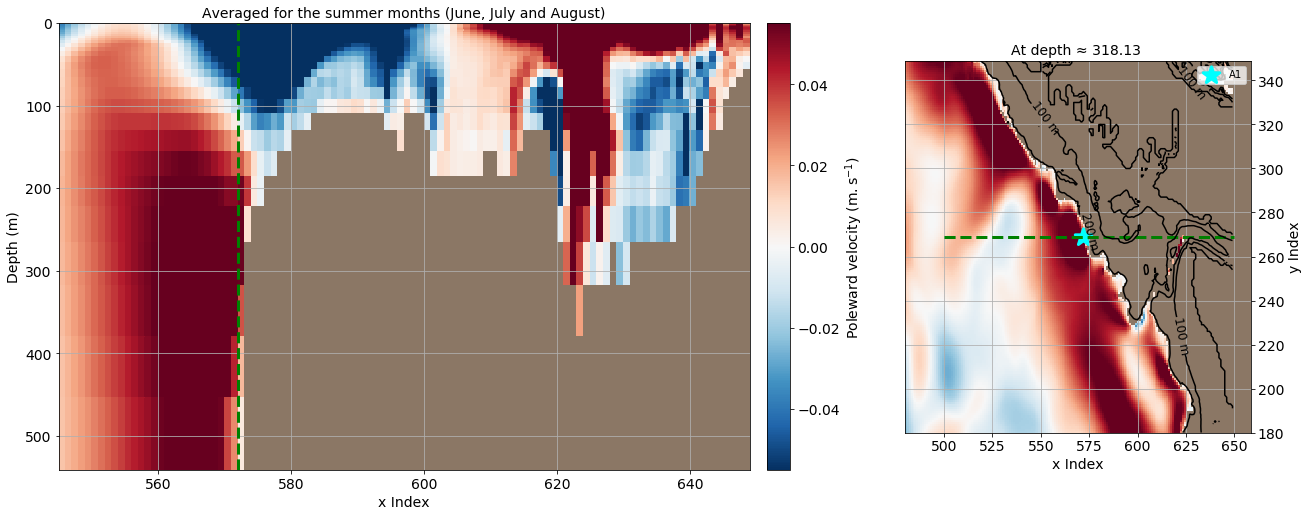

In [75]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
# land_colour = 'burlywood'
# cmap.set_bad('#8b7765')

land_colour = '#8b7765'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.74, 0.125, 0.02, 0.775))
axr.set_position((0.86, 0.125, 0.3, 0.775))

viz_tools.set_aspect(axr)
# cmap = plt.get_cmap('vlag')
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad(land_colour)


# arrow_step = 2
# q = axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,np.ma.array(spic_mean_august[level,...], mask = np.logical_not(sal_mean_august[level,...])), cmap=cmap, vmin = -0.2, vmax = 0)




# quiver = ax.quiver(x_wcvi_slice[70:-50:arrow_step], y_wcvi_slice[::arrow_step], u_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step], v_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step] , \
#                    mag_vel_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
# #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
# ax.quiverkey(quiver, 610, 320,  0.2, r'0.2 m/sec', coordinates = 'data')

mesh = axr.pcolormesh(x_wcvi_slice[:], y_wcvi_slice[:], v_unrotated_tzyx[28,:,:], cmap=cmap, vmin=-0.055, vmax =0.055)#, vmin=32, vmax=34)

axr.hlines(y=y_a1, xmin=500, xmax=650, color= 'green', linewidths=(3,), linestyle='--')
axr.scatter(
    x_a1, y_a1, marker='*',  s = 300, color='cyan', linewidths=(3,),
    label='A1',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.75)
# axr.set_title('Bathymetry Plot', fontsize = 14)
axr.set_xlabel('x Index', fontsize = 14)
axr.set_ylabel('y Index', fontsize = 14)
# CS1 = axr.contour(x_wcvi_slice[70:-50],y_wcvi_slice,Z[180:350,480+70:650-50], np.arange(100,110,10),colors='black')
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)
# CS1 = axr.contour(x_wcvi_slice[70:-50],y_wcvi_slice,Z[180:350,480+70:650-50], np.arange(200,210,10),colors='black')
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], np.arange(100,110,10),colors='black')
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)
CS1 = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], np.arange(200,210,10),colors='black')
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

axl.set_title('Averaged for the summer months (June, July and August)', fontsize=14)
axr.set_title('At depth \u2248 {d:.2f} '.format(d=zlevels[28]), fontsize = 14)
axr.tick_params(axis='both',labelsize =14)

# axr.clabel(CS)
# axr.set_xlim(right=600, left=550)
axr.yaxis.tick_right()
axr.yaxis.set_label_position("right")
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
# cmap = plt.get_cmap(cmo.cm.dense)
cmap.set_bad(land_colour)
# sal_0 = sal_july[t, :20, :,:]
spic_0 = spic_mean_august[:32,:,:]
spic_tzyx = np.ma.array(spic_0, mask = np.logical_not(sal_tzyx))


mesh = axl.pcolormesh(x_wcvi_slice[50:], zlevels[:32], v_unrotated_tzyx[:32,89,50:], cmap=cmap, vmin=-0.055, vmax =0.055)#, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Poleward velocity ($\mathrm{m.s^{-1}}$)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)

# rho_0 = rho_mean_august[:32,:,:]-1000
# rho_tzyx = np.ma.array(rho_0, mask = np.logical_not(sal_tzyx))
# rho_tzyx = np.ma.masked_values(rho_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])

# clines = axl.contour(x_wcvi_slice[50:], zlevels[:30], rho_tzyx[:30,89,50:], np.arange(26, 26.5, 0.05), colors='black')
# axl.clabel(clines, fmt='%1.2f', inline=True)

# clines = axl.contour(x_wcvi_slice[50:], zlevels[:30], rho_tzyx[:30,89,50:], np.arange(23, 23.8, 0.1), colors='black')
# axl.clabel(clines, fmt='%1.2f', inline=True)

axl.vlines(x=x_a1, ymax=zlevels[0], ymin=zlevels[31], color= 'green', linewidths=(3,), linestyle='--')

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')

axl.invert_yaxis()

axl.set_xlabel('x Index', fontsize = 14)
axl.set_ylabel('Depth (m)', fontsize = 14)
axl.tick_params(axis='both',labelsize =14)
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()

axl.set_xlim(xmin = 545)
# axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

In [76]:
v_0 = v_unrotated[153+17,:32,...]
v_unrotated_tzyx = np.ma.masked_values(v_0, 0)



/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


(545, 649.0)

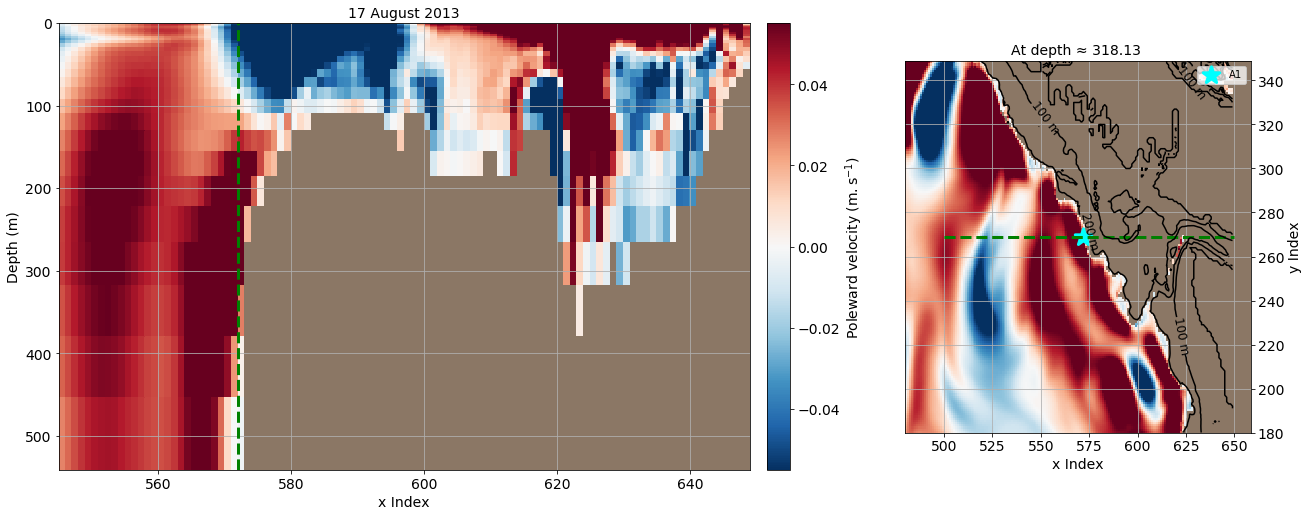

In [77]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
# land_colour = 'burlywood'
# cmap.set_bad('#8b7765')

land_colour = '#8b7765'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.74, 0.125, 0.02, 0.775))
axr.set_position((0.86, 0.125, 0.3, 0.775))

viz_tools.set_aspect(axr)
# cmap = plt.get_cmap('vlag')
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad(land_colour)


# arrow_step = 2
# q = axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,np.ma.array(spic_mean_august[level,...], mask = np.logical_not(sal_mean_august[level,...])), cmap=cmap, vmin = -0.2, vmax = 0)




# quiver = ax.quiver(x_wcvi_slice[70:-50:arrow_step], y_wcvi_slice[::arrow_step], u_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step], v_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step] , \
#                    mag_vel_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
# #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
# ax.quiverkey(quiver, 610, 320,  0.2, r'0.2 m/sec', coordinates = 'data')

mesh = axr.pcolormesh(x_wcvi_slice[:], y_wcvi_slice[:], v_unrotated_tzyx[28,:,:], cmap=cmap, vmin=-0.055, vmax =0.055)#, vmin=32, vmax=34)

axr.hlines(y=y_a1, xmin=500, xmax=650, color= 'green', linewidths=(3,), linestyle='--')
axr.scatter(
    x_a1, y_a1, marker='*',  s = 300, color='cyan', linewidths=(3,),
    label='A1',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.75)
# axr.set_title('Bathymetry Plot', fontsize = 14)
axr.set_xlabel('x Index', fontsize = 14)
axr.set_ylabel('y Index', fontsize = 14)
# CS1 = axr.contour(x_wcvi_slice[70:-50],y_wcvi_slice,Z[180:350,480+70:650-50], np.arange(100,110,10),colors='black')
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)
# CS1 = axr.contour(x_wcvi_slice[70:-50],y_wcvi_slice,Z[180:350,480+70:650-50], np.arange(200,210,10),colors='black')
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], np.arange(100,110,10),colors='black')
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)
CS1 = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], np.arange(200,210,10),colors='black')
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

axl.set_title('17 August 2013', fontsize=14)
axr.set_title('At depth \u2248 {d:.2f} '.format(d=zlevels[28]), fontsize = 14)
axr.tick_params(axis='both',labelsize =14)

# axr.clabel(CS)
# axr.set_xlim(right=600, left=550)
axr.yaxis.tick_right()
axr.yaxis.set_label_position("right")
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
# cmap = plt.get_cmap(cmo.cm.dense)
cmap.set_bad(land_colour)
# sal_0 = sal_july[t, :20, :,:]
spic_0 = spic_mean_august[:32,:,:]
spic_tzyx = np.ma.array(spic_0, mask = np.logical_not(sal_tzyx))


mesh = axl.pcolormesh(x_wcvi_slice[50:], zlevels[:32], v_unrotated_tzyx[:32,89,50:], cmap=cmap, vmin=-0.055, vmax =0.055)#, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Poleward velocity ($\mathrm{m.s^{-1}}$)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)

# rho_0 = rho_mean_august[:32,:,:]-1000
# rho_tzyx = np.ma.array(rho_0, mask = np.logical_not(sal_tzyx))
# rho_tzyx = np.ma.masked_values(rho_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])

# clines = axl.contour(x_wcvi_slice[50:], zlevels[:30], rho_tzyx[:30,89,50:], np.arange(26, 26.5, 0.05), colors='black')
# axl.clabel(clines, fmt='%1.2f', inline=True)

# clines = axl.contour(x_wcvi_slice[50:], zlevels[:30], rho_tzyx[:30,89,50:], np.arange(23, 23.8, 0.1), colors='black')
# axl.clabel(clines, fmt='%1.2f', inline=True)

axl.vlines(x=x_a1, ymax=zlevels[0], ymin=zlevels[31], color= 'green', linewidths=(3,), linestyle='--')

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')

axl.invert_yaxis()

axl.set_xlabel('x Index', fontsize = 14)
axl.set_ylabel('Depth (m)', fontsize = 14)
axl.tick_params(axis='both',labelsize =14)
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()

axl.set_xlim(xmin = 545)
# axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

In [78]:
v_0 = v_unrotated[153+1,:32,...]
v_unrotated_tzyx = np.ma.masked_values(v_0, 0)



/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


(545, 649.0)

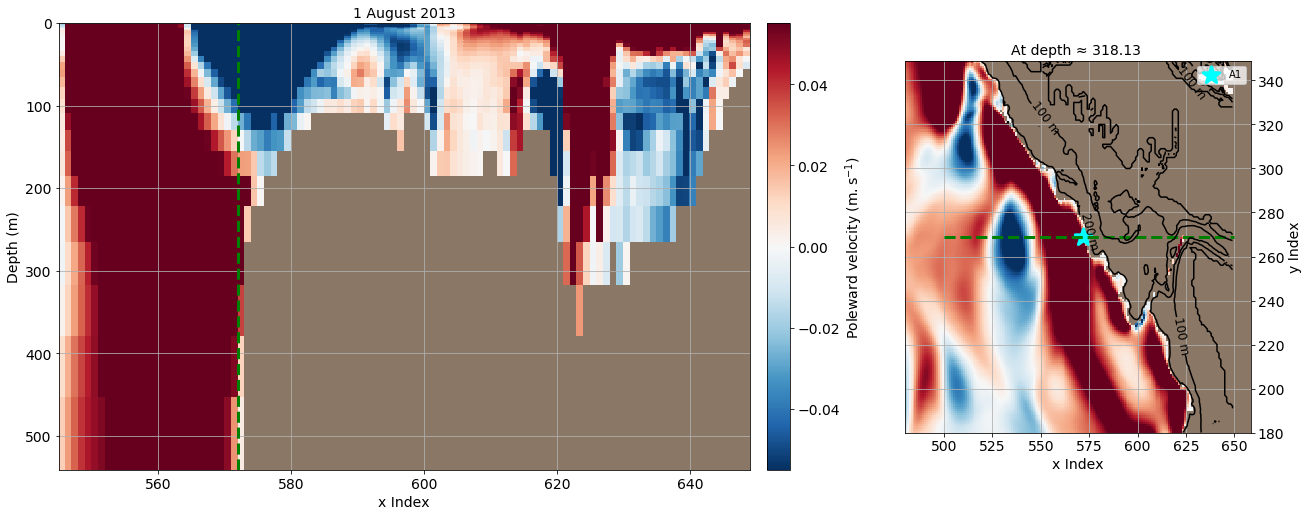

In [80]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
# land_colour = 'burlywood'
# cmap.set_bad('#8b7765')

land_colour = '#8b7765'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.74, 0.125, 0.02, 0.775))
axr.set_position((0.86, 0.125, 0.3, 0.775))

viz_tools.set_aspect(axr)
# cmap = plt.get_cmap('vlag')
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad(land_colour)


# arrow_step = 2
# q = axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,np.ma.array(spic_mean_august[level,...], mask = np.logical_not(sal_mean_august[level,...])), cmap=cmap, vmin = -0.2, vmax = 0)




# quiver = ax.quiver(x_wcvi_slice[70:-50:arrow_step], y_wcvi_slice[::arrow_step], u_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step], v_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step] , \
#                    mag_vel_unrotated_tzyx[28,::arrow_step,70:-50:arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
# #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
# ax.quiverkey(quiver, 610, 320,  0.2, r'0.2 m/sec', coordinates = 'data')

mesh = axr.pcolormesh(x_wcvi_slice[:], y_wcvi_slice[:], v_unrotated_tzyx[28,:,:], cmap=cmap, vmin=-0.055, vmax =0.055)#, vmin=32, vmax=34)

axr.hlines(y=y_a1, xmin=500, xmax=650, color= 'green', linewidths=(3,), linestyle='--')
axr.scatter(
    x_a1, y_a1, marker='*',  s = 300, color='cyan', linewidths=(3,),
    label='A1',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.75)
# axr.set_title('Bathymetry Plot', fontsize = 14)
axr.set_xlabel('x Index', fontsize = 14)
axr.set_ylabel('y Index', fontsize = 14)
# CS1 = axr.contour(x_wcvi_slice[70:-50],y_wcvi_slice,Z[180:350,480+70:650-50], np.arange(100,110,10),colors='black')
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)
# CS1 = axr.contour(x_wcvi_slice[70:-50],y_wcvi_slice,Z[180:350,480+70:650-50], np.arange(200,210,10),colors='black')
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], np.arange(100,110,10),colors='black')
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)
CS1 = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], np.arange(200,210,10),colors='black')
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

axl.set_title('1 August 2013', fontsize=14)
axr.set_title('At depth \u2248 {d:.2f} '.format(d=zlevels[28]), fontsize = 14)
axr.tick_params(axis='both',labelsize =14)

# axr.clabel(CS)
# axr.set_xlim(right=600, left=550)
axr.yaxis.tick_right()
axr.yaxis.set_label_position("right")
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
# cmap = plt.get_cmap(cmo.cm.dense)
cmap.set_bad(land_colour)
# sal_0 = sal_july[t, :20, :,:]
spic_0 = spic_mean_august[:32,:,:]
spic_tzyx = np.ma.array(spic_0, mask = np.logical_not(sal_tzyx))


mesh = axl.pcolormesh(x_wcvi_slice[50:], zlevels[:32], v_unrotated_tzyx[:32,89,50:], cmap=cmap, vmin=-0.055, vmax =0.055)#, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Poleward velocity ($\mathrm{m.s^{-1}}$)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)

# rho_0 = rho_mean_august[:32,:,:]-1000
# rho_tzyx = np.ma.array(rho_0, mask = np.logical_not(sal_tzyx))
# rho_tzyx = np.ma.masked_values(rho_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])

# clines = axl.contour(x_wcvi_slice[50:], zlevels[:30], rho_tzyx[:30,89,50:], np.arange(26, 26.5, 0.05), colors='black')
# axl.clabel(clines, fmt='%1.2f', inline=True)

# clines = axl.contour(x_wcvi_slice[50:], zlevels[:30], rho_tzyx[:30,89,50:], np.arange(23, 23.8, 0.1), colors='black')
# axl.clabel(clines, fmt='%1.2f', inline=True)

axl.vlines(x=x_a1, ymax=zlevels[0], ymin=zlevels[31], color= 'green', linewidths=(3,), linestyle='--')

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')

axl.invert_yaxis()

axl.set_xlabel('x Index', fontsize = 14)
axl.set_ylabel('Depth (m)', fontsize = 14)
axl.tick_params(axis='both',labelsize =14)
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()

axl.set_xlim(xmin = 545)
# axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

Answer: Yes, the CUC in the model shifts slightly offshore (but only slighly) for the whole of summer and more so for the days in August when there is a strong northward current (eg: 17 August).

Q) How does this influence our ideas about upwelling ?

